# COMP 534 - Applied Artificial Intelligence
## CA2 - Neural network regression
This notebook was produced as a deliverable for a group project for the above module, as part of the 2021-2022 Data Science and Artificial Intelligence MSc course at the University of Liverpool.
### Preparation
#### Setup
Import required libraries, tools and classifiers.

In [42]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Hyperparameter optimisation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

from tensorflow import keras

from keras.callbacks import EarlyStopping

from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#### Data
https://www.kaggle.com/datasets/harlfoxem/housesalesprediction

In [2]:
df = pd.read_csv('kc_house_data.csv')

In [3]:
# print(df.shape)
# df.head()

In [4]:
# df.hist(figsize=(20,20), bins='auto')
# plt.tight_layout()

#### Cleaning


##### Remove outliers

In [5]:
originalRowCount = df.shape[0]

df = df[(df['bedrooms'] > 0) & (df['bedrooms'] < 12)]
df = df[(df['bathrooms'] > 0) & (df['bathrooms'] < 12)]
df = df[df['sqft_lot'] < 5e5]
df = df[df['sqft_lot15'] < 3.5e5]

print(f'{((originalRowCount - df.shape[0])*100 / originalRowCount):.2f}% of rows removed')

0.22% of rows removed


##### Date

In [6]:
df['date'] = pd.to_datetime(df['date'])
df['daysSinceSale'] = (df['date'].max() - df['date']).dt.days

##### Binning

In [7]:
bins = 9
df['basementOrdinal'] = pd.cut(df[df['sqft_basement']>0]['sqft_basement'], bins, labels=range(1, bins+1)).astype(int)
df['basementOrdinal'] = df['basementOrdinal'].fillna(0)

In [8]:
bins = 9
df['renovatedOrdinal'] = pd.cut(df[df['yr_renovated']>0]['yr_renovated'], bins, labels=range(1, bins+1)).astype(int)
df['renovatedOrdinal'] = df['renovatedOrdinal'].fillna(0)

##### Transforms

In [9]:
skewedVariables = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15'] #'price', 
logVariables = ['priceLog', 'sqft_livingLog', 'sqft_lotLog', 'sqft_aboveLog', 'sqft_living15Log', 'sqft_lot15Log'] #'priceLog', 
df[logVariables] = np.log(df[skewedVariables])

##### Drop unused columns

In [10]:
df = df.drop(columns=skewedVariables)
df = df.drop(columns=['date', 'id', 'sqft_basement', 'yr_renovated', 'zipcode',])

##### Move price col

In [11]:
column_to_move = df.pop("priceLog")
df.insert(0, "priceLog", column_to_move)

In [12]:
# df.hist(bins = "auto", figsize = (20,20))
# plt.show()

### Models and Analysis

#### Setup

In [13]:
df.shape

(21566, 19)

In [22]:
data = df.values
X = data[:, 1:]
y = data[:, 0].reshape(-1, 1)

In [23]:
# Split data into 80% train and 20% test sets
# Data stratified by class due to imbalance in classes (65% negative - 35% positive)
# Data shuffled to reduce any bias in the order of the dataset
# Define random state to ensure the same train test split can be used for each method
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    #stratify=y,
                                                    shuffle=True,
                                                    random_state=123,
                                                    )

In [24]:
# Standardise features to negate the impact of different feature units
# Updated features have mean 0 and standard deviation 1
featureScaler = MinMaxScaler() #StandardScaler()
# featureScaler.fit(X_train[:, -5:])
# X_train[:, -5:] = featureScaler.transform(X_train[:, -5:])
# X_test[:, -5:] = featureScaler.transform(X_test[:, -5:])

featureScaler.fit(X_train)
X_train = featureScaler.transform(X_train)
X_test = featureScaler.transform(X_test)

In [25]:
targetScaler = StandardScaler()
targetScaler.fit(y_train)
y_train = targetScaler.transform(y_train)
y_test = targetScaler.transform(y_test)

#### Model

In [45]:
# define base model
def model():
    # create model
    model = Sequential()
    model.add(Dense(units=32, input_shape=(18,),  activation='relu'))
    model.add(Dense(units=32, activation='relu'))
#     model.add(Dense(16, input_dim=8, activation='relu'))
#     model.add(Dense(16, input_dim=8, activation='relu'))
    model.add(Dense(units=1))
    # Compile model
    #model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [32]:
trainFraction = 0.7
trainingRows = round((X_train.shape[0]*trainFraction))

model = baseline_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

history = model.fit(X_train[:trainingRows],
                    y_train[:trainingRows],
                    validation_data=(X_train[trainingRows:],
                                     y_train[trainingRows:]),
#                     validation_data=(X_test,
#                                      y_test),
                    epochs=1000,
                    batch_size=128,
                    verbose=0,
                    callbacks=[es],
                   )

train_acc = model.evaluate(X_train[:trainingRows],
                              y_train[:trainingRows],
                              verbose=0)
valid_acc = model.evaluate(X_train[trainingRows:],
                             y_train[trainingRows:],
                             verbose=0)

print(f'Train: {train_acc:.3f}\nValid: {valid_acc:.3f}')


# verbose=0)
#y_pred = model.predict(X_test)

Epoch 00592: early stopping
Train: 0.090
Valid: 0.105


https://coderzcolumn.com/tutorials/artifical-intelligence/scikeras-give-scikit-learn-like-api-to-your-keras-networks

In [ ]:
searchSpace = {
    'optimizer':[],
    'optimizer__learning_rate': [],
    'batch_size':[],
}


# params = {
#     "batch_size": [8,16],
#     "optimizer": ["adam", "sgd"],
#     "optimizer__learning_rate": [0.001, 0.01, 0.1],

In [52]:
#aModel = model()
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)

estimator = KerasRegressor(model=model,
                           #model=aModel,
                           optimizer='adam',
                           loss=keras.losses.mean_squared_error,
                           epochs=1000,
                           batch_size=128,
                           verbose=0,
                           callbacks=[es],
                          )


kfold = KFold(n_splits=10)

results = cross_val_score(estimator, X_train, y_train, cv=kfold)

results.mean()

Epoch 00142: early stopping
Epoch 00115: early stopping
Epoch 00134: early stopping
Epoch 00148: early stopping
Epoch 00204: early stopping
Epoch 00215: early stopping
Epoch 00194: early stopping
Epoch 00136: early stopping
Epoch 00150: early stopping
Epoch 00162: early stopping


0.8902102850322569

In [53]:
estimator.fit(X_train,y_train)

Epoch 00195: early stopping


KerasRegressor(
	model=<function model at 0x0000022516173048>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=<function mean_squared_error at 0x000002250F10DDC8>
	metrics=None
	batch_size=128
	validation_batch_size=None
	verbose=0
	callbacks=[<keras.callbacks.EarlyStopping object at 0x00000225160D8C48>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1000
)

In [ ]:
hyperparameterSearch = GridSearchCV(algorithm, searchSpace, scoring='neg_mean_squared_error', n_jobs=-1, cv=crossValidator)
# Fit search with training data
# Performs search over searchSpace
hyperparameterSearch.fit(X_train, y_train)

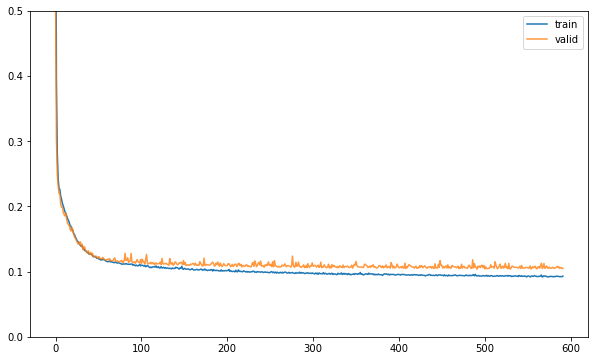

In [35]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='valid', alpha=0.8)

#ax.set(yscale="log") #xscale="log", 

ax.set_ylim([0, 0.5])

plt.legend()
plt.show()

1. Learning Rate
2. Batch Size
3. Number of epochs
4. Activation functions
5. Optimizers
6. Loss function
7. Number of Hidden Layers
8. Number of nodes in the hidden layers

In [ ]:
sklearn.metrics.SCORERS.keys()

https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

### Search space

In [ ]:
# Function to optimise algorithm hyperparameters
# Performs grid search with cross validation to evaluate hyperparameter combinations
# Takes:
# - algorithm: machine learning model object
# - searchSpace: dictionary containing hyperparameter names (keys) and list of values to search through (values)
# - X_train: training data feature values
# - y_train: training data class labels
def hyperparameterTuner(algorithm, searchSpace, X_train, y_train):
    # Initialise cross validator
    # Repeated to account for variance across samples
    # Stratified to ensure constant proportion of each classes in each fold
    crossValidator = RepeatedKFold(n_splits=7, random_state=1, n_repeats=2)
    # Initialise search
    # Grid search to perform exhaustive search of all hyperparameter combinations in searchSpace
    hyperparameterSearch = GridSearchCV(algorithm, searchSpace, scoring='neg_mean_squared_error', n_jobs=-1, cv=crossValidator)
    # Fit search with training data
    # Performs search over searchSpace
    hyperparameterSearch.fit(X_train, y_train)
    return hyperparameterSearch

In [ ]:
searchSpace = {
    'epochs': [3,4,5], # 'n_neighbors': 5,
}

In [ ]:
# Create KNN classifier for hyperparameter search
#knnSearchModel = KNeighborsClassifier()
searchEstimator = KerasRegressor(model=baseline_model, verbose=0)

In [ ]:
#model=baseline_model()
# Perform search based on search space
search = hyperparameterTuner(searchEstimator, searchSpace, X_train, y_train)

In [ ]:
# Store best parameters found
optimumParameters = search.best_params_
print(optimumParameters)
# Store all results in new dataframe
results = pd.DataFrame(search.cv_results_)
results

In [ ]:
# evaluate model
estimator = KerasRegressor(model=baseline_model, epochs=5, batch_size=32, verbose=0)
kfold = KFold(n_splits=5)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [ ]:
results

#### Test

In [ ]:
y_pred = model.predict(X_test)

In [54]:
y_pred = estimator.predict(X_test)

In [55]:
# invert transform on predictions
#yhat = model.predict(test_X)
y_test = targetScaler.inverse_transform(y_test)
y_pred = targetScaler.inverse_transform(y_pred)

In [56]:
y_test = y_test.reshape(y_test.shape[0])
y_pred = y_pred.reshape(y_pred.shape[0])

In [59]:
y_test = np.exp(y_test)
y_pred = np.exp(y_pred)

Text(0, 0.5, 'Prediction')

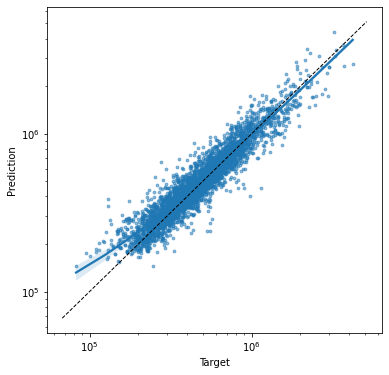

In [60]:
fig, ax = plt.subplots(figsize=(6,6))

ax = sns.regplot(x=y_test,
                 y=y_pred,
                 scatter_kws={'s':8,
                              'alpha':0.5},                
               )

ax.set(xscale="log", yscale="log")

xpoints = ypoints = ax.get_xlim()
ax.plot(xpoints, ypoints, linestyle='--', color='k', lw=1)#, scalex=False, scaley=False)

#ax = sns.lineplot(x=[0,1], y=[0,1])#, transform=ax.transAxes)

#ax.axis('equal')

ax.set_xlabel('Target')
ax.set_ylabel('Prediction')

In [61]:
errors = mean_squared_error(y_test, y_pred, squared=False) 
print(errors)

123924.88159548426


In [ ]:
y_test.mean()